# Analysis of edits

This notebook can be roughly subdivided into three parts. First, the edit data is cleaned and transformed. Next, correlations of article-language pairs are calculated and summarised. Last part deals with burstiness of edit activity.

## Data import

Detailed edit data are located in detailed_data folder in three files, one for each of the topics analysed.

In [29]:
## Setup + data import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import itertools

wikiData_US = pd.read_csv("../data/detailed_data/detailedEdits_US_Civil_War_2024-07-13-11-04.csv")
wikiData_US['topic'] = 'US_Civil_War'
wikiData_UA = pd.read_csv("../data/detailed_data/detailedEdits_Ukraine_2024-07-14-04-49.csv")
wikiData_UA['topic'] = 'Ukraine'
wikiData_IP = pd.read_csv("../data/detailed_data/detailedEdits_Israel_Palestine_2024-07-13-19-16.csv")
wikiData_IP['topic'] = 'Israel/Palestine'


wikiData_all = pd.concat([wikiData_UA, wikiData_US, wikiData_IP])[['user', 'timestamp', 'size', 'reverted', 'reversion', 'topic', 'article', 'language', 'total_edits', 'article_edits']].drop_duplicates()
wikiData_all['ratio_edits'] = (wikiData_all['article_edits']/wikiData_all['total_edits']).replace(np.inf, 1.01) # mostly edits by anonymous users we do not have totals available for

wikiData_all['timestamp'] = pd.to_datetime(wikiData_all['timestamp'])
wikiData_all['month'] = wikiData_all['timestamp'].dt.month
wikiData_all['year'] = wikiData_all['timestamp'].dt.year

wikiData_all[wikiData_all['reversion'] == 1].sort_values('timestamp').head()

,user,timestamp,size,reverted,reversion,topic,article,language,total_edits,article_edits,ratio_edits,month,year
92500,Triggerhippie4,2018-01-05 12:10:02,84050,0,1,Israel/Palestine,Hebrew_language,en,20357,43,0.002112,1,2018
12051,Karl.i.biased,2018-01-06 01:32:19,80177,0,1,Ukraine,Stepan_Bandera,en,1606,35,0.021793,1,2018
47267,Acroterion,2018-01-07 03:49:51,84121,0,1,US_Civil_War,James_Longstreet,en,226660,1,0.000004,1,2018
160355,Андрей Романенко,2018-01-07 14:55:57,107356,0,1,Ukraine,Ukrainian_People's_Republic,ru,119014,2,0.000017,1,2018
192460,Юрий Владимирович Л.,2018-01-07 17:16:16,189164,0,1,Ukraine,Nikolai_Gogol,ru,85745,2,0.000023,1,2018


As the next step, wikiData_grouped dataframe is created for analysing edits by month

In [30]:
wikiData_grouped = wikiData_all.groupby(['topic', 'article', 'language', 'year', 'month']).agg(
    edits = ('timestamp', 'size'),
    reverted_edits = ('reverted', 'sum'),
    reversions = ('reversion', 'sum'),
    mean_size = ('size', 'mean')
).reset_index()

first_edits = wikiData_all.groupby(['article', 'language'])['timestamp'].min().reset_index().rename(columns={'timestamp': 'first_edit'})

wikiData_grouped = wikiData_grouped.merge(first_edits, on=['article', 'language'])

wikiData_grouped


,topic,article,language,year,month,edits,reverted_edits,reversions,mean_size,first_edit
0,Israel/Palestine,1929_Hebron_massacre,ar,2007,7,6,0,0,725.833333,2007-07-19 13:55:39
1,Israel/Palestine,1929_Hebron_massacre,ar,2007,8,1,0,0,916.000000,2007-07-19 13:55:39
2,Israel/Palestine,1929_Hebron_massacre,ar,2007,10,5,0,0,4190.000000,2007-07-19 13:55:39
3,Israel/Palestine,1929_Hebron_massacre,ar,2007,12,2,0,0,5977.500000,2007-07-19 13:55:39
4,Israel/Palestine,1929_Hebron_massacre,ar,2008,1,1,0,0,5838.000000,2007-07-19 13:55:39
...,...,...,...,...,...,...,...,...,...,...
55998,Ukraine,Zaporozhian_Cossacks,uk,2023,3,1,0,0,20918.000000,2008-04-29 14:22:24
55999,Ukraine,Zaporozhian_Cossacks,uk,2023,4,1,0,0,20918.000000,2008-04-29 14:22:24
56000,Ukraine,Zaporozhian_Cossacks,uk,2023,8,1,0,0,21295.000000,2008-04-29 14:22:24
56001,Ukraine,Zaporozhian_Cossacks,uk,2023,12,1,0,0,21477.000000,2008-04-29 14:22:24


insert_empty_intervals() is needed for having months with 0 edits within our dataset. When already aggregating, we also insert columns total_edits, total_reversions and total_reverted with counts covering the entire existence of the Wikipeduia article.

In [31]:
def insert_empty_intervals(df : pd.DataFrame, oldest : datetime = datetime(2005,1,1)) -> pd.DataFrame :

    """
    Inserts months in the df to also capture months with no edit activity.
    """

    articles = df['article'].unique()
    langs = df['language'].unique()
    years = df['year'].sort_values(ascending = True).unique()
    months = df['month'].sort_values(ascending = True).unique()

    cartesian_product = list(itertools.product(articles, langs, years, months))

    df_cartesian_product = pd.DataFrame(cartesian_product, columns=['article', 'language', 'year', 'month'])

    result_df = pd.merge(df_cartesian_product, df, how = 'left', on = ['article', 'language', 'year', 'month'])
    

    result_df = result_df.drop(columns = ['first_edit', 'topic'], errors='ignore')
    result_df = result_df.merge(first_edits, on=['article', 'language'], how='left')
    result_df = result_df.merge(df[['topic', 'article']].drop_duplicates(), on = 'article', how='left')
        

    result_df['edits'] = result_df['edits'].fillna(0)
    result_df['reverted_edits'] = result_df['reverted_edits'].fillna(0)
    result_df['reversions'] = result_df['reversions'].fillna(0)

    result_df = result_df[result_df['year'] >= oldest.year]
    result_df = result_df[result_df['year'] >= result_df['first_edit'].dt.year]
    result_df = result_df[(result_df['year'] > result_df['first_edit'].dt.year) | (result_df['month'] >= result_df['first_edit'].dt.month)]

    grouped = result_df.groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped, on=['article', 'language'], how='left')

    grouped2 = result_df[(result_df['year'] > 2020) | ((result_df['year'] == 2020) & (result_df['month'] > 8))].groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped2, on=['article', 'language'], how='left', suffixes=['', '_after_aug2020'])
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))



    return result_df[
        ['topic', 'article', 'language', 'date', 'edits', 'reverted_edits', 'reversions', 'mean_size', 'first_edit', 'total_edits', 'total_reversions', 'total_reverted', 'total_edits_after_aug2020', 'total_reversions_after_aug2020', 'total_reverted_after_aug2020']
    ].sort_values('date')

In [32]:
print(len(wikiData_grouped))

wikiData = insert_empty_intervals(wikiData_grouped)

print(len(wikiData))


56003
82886


## Correlation analysis

In [33]:
## Number of unique article-language observations
len(wikiData[['article', 'language']].drop_duplicates())

372

371 unique article-language observations means there are $\frac{371 \cdot 370}{2} = 68635$ unique article-language pairs

In [34]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def filter_edits(article : str = None, lang : str = None, topic : str = None, df : pd.DataFrame = wikiData) -> pd.DataFrame:

    """Filters for subset of the inputed dataframe"""

    filter_df = df

    if article is not None and lang is not None:
        filter_df = filter_df [ filter_df['article'] == article ]
    if lang is not None and lang is not None:
        filter_df = filter_df [ filter_df['language'] == lang ]
    if topic is not None:
        filter_df = filter_df [ filter_df['topic'] == topic ]

    return filter_df

def transform_count(filter_df : pd.DataFrame = wikiData) -> pd.Series:

    """Normalizes edit count by substracting mean and dividing by standard deviation to allow for better comparisons"""

    filter_df = filter_df.groupby('date').agg(edits = ('edits', 'sum'))
    edits = filter_df['edits']

    return (edits - edits.mean()) / edits.std()
     

def transform_counts(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData) :

    """
    Creates two subsets of edits , also filters by date to obtain intersection of the time spans to achieve uniform length.
    Then calls transform_count() on the two edit count series.
    """

    filter_df_1 = filter_edits(article1, lang1, topic1, df)
    filter_df_2 = filter_edits(article2, lang2, topic2, df)

    filter_df_1 = filter_df_1[filter_df_1['date'].isin(filter_df_2['date'])]
    filter_df_2 = filter_df_2[filter_df_2['date'].isin(filter_df_1['date'])]

    series_1 = transform_count(filter_df = filter_df_1)
    series_2 = transform_count(filter_df = filter_df_2)
    
    return series_1, series_2

def correlation_edits(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData):

    """Retrieves relevant normalised edit series and calculates their correlation"""

    series1, series2 = transform_counts(article1, lang1, article2, lang2, topic1, topic2, df)
    correlation, _ = pearsonr(series1, series2)
    
    return correlation, _

def plot_correlation(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData):
    
    """Retrieves correlation and plots the two times series of normalised edit counts"""

    series1, series2 = transform_counts(article1, lang1, article2, lang2, topic1, topic2, df)
    correlation, _ = pearsonr(series1, series2)
    print(pearsonr(series1, series2))

    plt.figure(figsize=(10, 6))
    plt.plot(df['date'].unique()[-len(series1):], series1, label= "{} , {}".format(article1, lang1) , color='blue')
    plt.plot(df['date'].unique()[-len(series2):], series2, label= "{} , {}".format(article2, lang2) , color='red')

    plt.xlabel('Date')
    plt.ylabel('Relative count of edits')
    plt.title('Pearson correlation: %.3f' % correlation)
    plt.legend()

    plt.show()
    

correlation_edits('Abraham_Lincoln', 'en', 'Abraham_Lincoln', 'de')[0]


0.34351879984983835

PearsonRResult(statistic=0.8617285317695897, pvalue=8.686222552870878e-51)


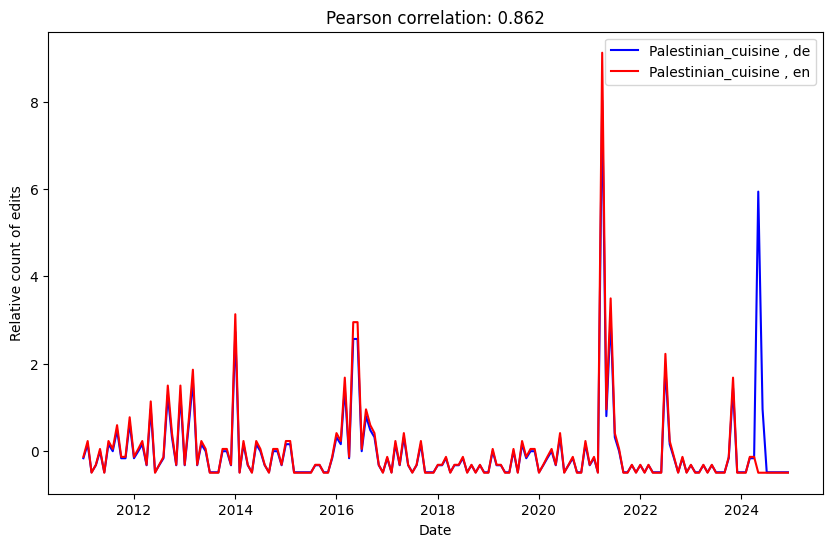

In [35]:
plot_correlation('Palestinian_cuisine', 'de', 'Palestinian_cuisine', 'en', df=wikiData[(wikiData['date'] >= datetime(2011,1,1))])
	

In [36]:
def calculate_correlations(df : pd.DataFrame = wikiData) -> pd.DataFrame:

    """Calculates correlation for each pair of article-language in the input dataframe."""

    correlations = pd.DataFrame(columns=['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value'])
    
    df = df[df['total_edits'] > 0]

    unique_pairs = list(df.drop_duplicates(subset=['article', 'language'])[['article', 'language']].to_records(index=False))

    for c in itertools.combinations(unique_pairs, 2):
        
        try:
 
            correlation = correlation_edits(c[0][0], c[0][1], c[1][0], c[1][1], df=df)
            row = pd.DataFrame({'Article1': [c[0][0]], 'Article2' : [c[1][0]], 'Lang1' : [c[0][1]], 'Lang2' : [c[1][1]], 'Correlation' : [correlation[0]], 'P_value' : [correlation[1]]})
            correlations=pd.concat([correlations, row])
        except:
            continue

    return correlations

def join_topics(topics_df : pd.DataFrame, df : pd.DataFrame) -> pd.DataFrame:
    
    """Joins topic for each of the two article-languages in a pair"""

    df = pd.merge(df, topics_df, 'left', left_on = 'Article1', right_on = 'Article')[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic']]
    df = pd.merge(df, topics_df, 'left', left_on = 'Article2', right_on = 'Article', suffixes = ['_1', '_2'])[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic_1', 'Topic_2']]

    return df

def determine_group(row) -> str :
    
    """Based on article, language, topic, assigns one of four groups"""

    return_value = ''
    if row['Article1'] == row['Article2'] and row['Lang1'] != row['Lang2']:
        return 'Same Article'
    
    if row['Topic_1'] == row['Topic_2']:
        return_value += 'Same Topic'
        if row['Lang1'] == row['Lang2']:
            return_value += ', Same language '
            
    if return_value == '':
        return_value += 'Nothing common'

    return return_value


def assign_groups(df):

    df['Group'] = df.apply(determine_group, axis=1)
    return df

def correlations_topics_groups(df: pd.DataFrame, topics_df: pd.DataFrame) -> pd.DataFrame:

    """For each pair of article-languages, calculates correlation, assigns topic to both and determines pair group"""
    
    df_correlations = calculate_correlations(df)
    print("Correlations calculated")

    df_topics = join_topics(topics_df, df_correlations)
    print("Topics assigned")

    df_groups = assign_groups(df_topics)
    print("Groups assigned")

    df_groups = df_groups.sort_values('Correlation', ascending = False)
    
    return df_groups

In [37]:
topics = {
    'Ukraine' : 
    ["Kyiv","Kievan_Rus'","Stepan_Bandera","Bohdan_Khmelnytsky","Cossacks","Ukrainian_language","Holodomor","Borscht","Symon_Petliura",
    "Ukrainian_People's_Republic","Mykhailo_Hrushevsky","Nikolai_Gogol","Taras_Shevchenko","Ukrainian_literature","Ivan_Franko","Ukrainian_Insurgent_Army","Organisation_of_Ukrainian_Nationalists","Pierogi",
    "Kolach_(bread)", "Paska_(bread)", "Pampushka", "Syrniki", "Rusyns", "Vyshyvanka", "Ukrainian_Soviet_Socialist_Republic", "Pereiaslav_Agreement", "West_Ukrainian_People's_Republic", 
    "Massacres_of_Poles_in_Volhynia_and_Eastern_Galicia", "Orange_Revolution", "Ukrainian_War_of_Independence", "Principality_of_Kiev", "Kyiv_Pechersk_Lavra","Golden_Gate,_Kyiv", "Bakhchysarai_Palace", 
    "Khreshchatyk", "Kamianets-Podilskyi_Castle",  "Saint_Sophia_Cathedral,_Kyiv", "Kobzar", "Hryhorii_Skovoroda", "Lesya_Ukrainka", "Rus'_people", "Zaporozhian_Cossacks", "Khmelnytsky_Uprising"],

    'Israel/Palestine' : 
    ["Nakba","Mandatory_Palestine","1948_Arab-Israeli_War","David_Ben-Gurion","Yasser_Arafat","Six-Day_War","Yom_Kippur_War","Hummus","Falafel","Shawarma","First_Intifada",
     "United_Nations_Partition_Plan_for_Palestine", "Intercommunal_conflict_in_Mandatory_Palestine", "Lehi_(militant_group)", "Irgun", "Ze'ev_Jabotinsky",
     "Haganah", "1947–1948_civil_war_in_Mandatory_Palestine", "1948_Arab–Israeli_War", "Yitzhak_Rabin", "Palmach", "Moshe_Dayan", "Jewish_exodus_from_the_Muslim_world", 
     "1936–1939_Arab_revolt_in_Palestine", "Amin_al-Husseini", "1948_Palestinian_expulsion_and_flight", "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war", "Plan_Dalet", 
     "Abd_al-Qadir_al-Husayni", "1929_Hebron_massacre", "Causes_of_the_1948_Palestinian_expulsion_and_flight", "Deir_Yassin_massacre", "Menachem_Begin", "Kfar_Etzion_massacre", "Hebrew_language", 
     "Suez_Crisis", "Six-Day_War", "Egypt–Israel_peace_treaty", "Palestinian_Arabic", "Culture_of_Palestine", "Palestinian_cuisine", "Samih_al-Qasim", "Mahmoud_Darwish", "Origin_of_the_Palestinians"],
    
    
    'US_Civil_War' : 
    ["Ulysses_S._Grant","Sherman's_March_to_the_Sea","William_Tecumseh_Sherman","Union_Army","Confederate_States_Army","Robert_E._Lee","Joseph_E._Johnston","Alexander_H._Stephens","James_Longstreet",
     "United_Daughters_of_the_Confederacy","Army_of_Northern_Virginia","Jefferson_Davis","Origins_of_the_American_Civil_War","Confederate_States_of_America","Abraham_Lincoln","Battle_of_Gettysburg", 
     "Judah_P._Benjamin", "John_C._Breckinridge", "Joseph_Wheeler", "P._G._T._Beauregard", "Franklin_Buchanan", "Nathan_Bedford_Forrest", "Ku_Klux_Klan", "John_C._Frémont", "Joseph_Hooker", "George_Meade", 
     "Wilmington_massacre", "Red_Shirts_(United_States)", "United_Confederate_Veterans", "Confederate_History_Month", "Robert_E._Lee_Day", "Stonewall_Jackson", "Jim_Crow_laws", "John_Brown_(abolitionist)", 
     "William_Lloyd_Garrison", "Frederick_Douglass", "Thaddeus_Stevens", "Battle_of_the_Wilderness", "Battle_of_Antietam", "Reconstruction_era", "Emancipation_Proclamation", 
     "Thirteenth_Amendment_to_the_United_States_Constitution", "Slavery_in_the_United_States", "States'_rights", "Historiographic_issues_about_the_American_Civil_War"],
}

topics_df = pd.DataFrame([(key, value) for key in topics for value in topics[key]], columns=['Topic', 'Article'])

topics_df

,Topic,Article
0,Ukraine,Kyiv
1,Ukraine,Kievan_Rus'
2,Ukraine,Stepan_Bandera
3,Ukraine,Bohdan_Khmelnytsky
4,Ukraine,Cossacks
...,...,...
127,US_Civil_War,Emancipation_Proclamation
128,US_Civil_War,Thirteenth_Amendment_to_the_United_States_Cons...
129,US_Civil_War,Slavery_in_the_United_States
130,US_Civil_War,States'_rights


summarise_correlations() splits article-language pairs according to correlation. Then , it calculates shares of pairs' in high asnd low correlation buckets. Comparing the shares, we can see if a pair group is over or underrepresented in highly-correlated pairs bucket.

In [38]:
def summarise_correlations(df):

    """Shows absolute and relative share of article-language pair groups in high and low correlated buckets."""
    
    print("\n All \n")
    print(df['Group'].value_counts(normalize=True).reset_index())
    print(df['Group'].value_counts().reset_index())
    print("\n >= 0.4 \n")
    print(df[df['Correlation'] >= 0.4]['Group'].value_counts(normalize=True).reset_index())
    print(df[df['Correlation'] >= 0.4]['Group'].value_counts().reset_index())
    print("\n < 0.4 \n")
    print(df[df['Correlation'] < 0.4]['Group'].value_counts(normalize=True).reset_index())
    

Having defined all necessary function for calculating correlations and determining groups for each pair of article-language, we can apply them to our dataset. In some of the examples, the calculation is limited by timestamp or total_edits. This is due to many articles having many edits and high burstiness before 2010s, resulting in a common L-shaped edit counts graph. The high monthly edit counts before 2010 would decrease significance of highs and bottoms in the most recent years. Limiting total_edits helps selecting articles with edit activity in most of the covered months.

In [39]:
correlation_500 = correlations_topics_groups(wikiData[(wikiData['total_edits'] > 500) & (wikiData['date'] >= datetime(2011,1,1))], topics_df)


Correlations calculated
Topics assigned
Groups assigned


In [40]:
summarise_correlations(correlation_500)
correlation_500.head(20)



 All 

                        Group  proportion
0              Nothing common    0.643192
1                  Same Topic    0.216249
2  Same Topic, Same language     0.133459
3                Same Article    0.007100
                        Group  count
0              Nothing common  13316
1                  Same Topic   4477
2  Same Topic, Same language    2763
3                Same Article    147

 >= 0.4 

                        Group  proportion
0              Nothing common    0.449704
1  Same Topic, Same language     0.325444
2                  Same Topic    0.189349
3                Same Article    0.035503
                        Group  count
0              Nothing common     76
1  Same Topic, Same language      55
2                  Same Topic     32
3                Same Article      6

 < 0.4 

                        Group  proportion
0              Nothing common    0.644784
1                  Same Topic    0.216470
2  Same Topic, Same language     0.131879
3            

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
5753,Thaddeus_Stevens,Thirteenth_Amendment_to_the_United_States_Cons...,en,en,0.864343,1.995379e-51,US_Civil_War,US_Civil_War,"Same Topic, Same language"
13920,Palestinian_cuisine,Palestinian_cuisine,de,en,0.861729,8.686223e-51,Israel/Palestine,Israel/Palestine,Same Article
15278,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.826736,2.538236e-43,Israel/Palestine,Israel/Palestine,Same Article
472,Ukrainian_War_of_Independence,Khreshchatyk,en,en,0.756236,2.135459e-32,Ukraine,Ukraine,"Same Topic, Same language"
13800,United_Nations_Partition_Plan_for_Palestine,Nakba,en,en,0.745643,4.186167e-09,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
2462,Yasser_Arafat,Yasser_Arafat,de,en,0.716201,1.006557e-27,Israel/Palestine,Israel/Palestine,Same Article
13200,First_Intifada,Nakba,en,en,0.708109,5.305937e-08,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
19217,Jefferson_Davis,Nakba,de,en,0.674672,3.733249e-07,US_Civil_War,Israel/Palestine,Nothing common
3691,Massacres_of_Poles_in_Volhynia_and_Eastern_Gal...,James_Longstreet,ru,en,0.654028,7.107754e-22,Ukraine,US_Civil_War,Nothing common
15950,Yasser_Arafat,Nakba,en,en,0.633727,2.968594e-06,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"


In [41]:
correlation_200 = correlations_topics_groups(wikiData[(wikiData['total_edits'] > 200)  & (wikiData['date'] >= datetime(2011,1,1))], topics_df)


Correlations calculated
Topics assigned
Groups assigned


In [42]:
## Similar to previous result
summarise_correlations(correlation_200)


 All 

                        Group  proportion
0              Nothing common    0.637877
1                  Same Topic    0.240501
2  Same Topic, Same language     0.115514
3                Same Article    0.006108
                        Group  count
0              Nothing common  29764
1                  Same Topic  11222
2  Same Topic, Same language    5390
3                Same Article    285

 >= 0.4 

                        Group  proportion
0              Nothing common    0.500000
1  Same Topic, Same language     0.267974
2                  Same Topic    0.202614
3                Same Article    0.029412
                        Group  count
0              Nothing common    153
1  Same Topic, Same language      82
2                  Same Topic     62
3                Same Article      9

 < 0.4 

                        Group  proportion
0              Nothing common    0.638788
1                  Same Topic    0.240751
2  Same Topic, Same language     0.114508
3            

In [43]:
correlation_200.head(10)

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
14422,Thaddeus_Stevens,Thirteenth_Amendment_to_the_United_States_Cons...,en,en,0.864343,1.995379e-51,US_Civil_War,US_Civil_War,"Same Topic, Same language"
32640,Palestinian_cuisine,Palestinian_cuisine,de,en,0.861729,8.686223e-51,Israel/Palestine,Israel/Palestine,Same Article
35382,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.826736,2.538236e-43,Israel/Palestine,Israel/Palestine,Same Article
17742,William_Tecumseh_Sherman,Origin_of_the_Palestinians,de,en,0.771127,1.792575e-04,US_Civil_War,Israel/Palestine,Nothing common
23657,Historiographic_issues_about_the_American_Civi...,Origin_of_the_Palestinians,en,en,0.763535,2.267441e-04,US_Civil_War,Israel/Palestine,Nothing common
28706,Kobzar,Nakba,en,en,0.759546,1.457523e-09,Ukraine,Israel/Palestine,Nothing common
1322,Ukrainian_War_of_Independence,Khreshchatyk,en,en,0.756236,2.135459e-32,Ukraine,Ukraine,"Same Topic, Same language"
46099,Egypt–Israel_peace_treaty,Origin_of_the_Palestinians,ar,en,0.750507,3.329182e-04,Israel/Palestine,Israel/Palestine,Same Topic
31954,United_Nations_Partition_Plan_for_Palestine,Nakba,en,en,0.745643,4.186167e-09,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
41510,Ukrainian_People's_Republic,Origin_of_the_Palestinians,en,en,0.745293,3.857976e-04,Ukraine,Israel/Palestine,Nothing common


## Burstiness

In [44]:
import matplotlib.pyplot as plt

def calculate_intervals(article : str = None, lang : str = None, topic : str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all) -> pd.Series :

    # get relevant data
    
    filtered_df = edits_df

    if article is not None:
        filtered_df = filtered_df[filtered_df['article'] == article]
    if lang is not None:
        filtered_df = filtered_df[filtered_df['language'] == lang]
    if topic is not None:
        filtered_df = filtered_df[filtered_df['topic'] == topic]
    if timestart is not None:
        filtered_df = filtered_dffiltered_df = filtered_df[filtered_df['language'] == lang][filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    intervals = filtered_df['timestamp'].diff().dt.total_seconds() / 3600 # convert difference to float representing hours
    
    return intervals[1:] #first value is always NaN

def burstiness(article : str = None, lang : str = None, topic :str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all) -> float:

    intervals = calculate_intervals(article = article, lang = lang, timestart = timestart, timestop = timestop, edits_df = edits_df)

    mean_interval = intervals.mean()
    std_interval = intervals.std()

    return (std_interval - mean_interval) / (std_interval + mean_interval)

In [45]:
wikiData_all

,user,timestamp,size,reverted,reversion,topic,article,language,total_edits,article_edits,ratio_edits,month,year
0,Kwamikagami,2024-06-19 07:56:47,164242,0,0,Ukraine,Kyiv,en,470615,8,0.000017,6,2024
1,Kwamikagami,2024-06-19 07:56:22,164250,0,0,Ukraine,Kyiv,en,470615,8,0.000017,6,2024
2,Ray the Anarchist,2024-06-13 10:32:43,164253,0,0,Ukraine,Kyiv,en,804,10,0.012438,6,2024
3,Ray the Anarchist,2024-06-13 10:32:26,164254,0,0,Ukraine,Kyiv,en,804,10,0.012438,6,2024
4,Mellk,2024-06-06 05:09:58,164292,0,0,Ukraine,Kyiv,en,47108,3,0.000064,6,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149883,Mr.Ibrahembot,2023-09-05 15:45:32,25087,0,0,Israel/Palestine,Origin_of_the_Palestinians,ar,10699732,16,0.000001,9,2023
149884,LokasBot,2023-09-05 15:42:27,25885,0,0,Israel/Palestine,Origin_of_the_Palestinians,ar,256446,1,0.000004,9,2023
149885,Mr.Ibrahembot,2023-09-05 15:37:46,25770,0,0,Israel/Palestine,Origin_of_the_Palestinians,ar,10699732,16,0.000001,9,2023
149886,Mr.Ibrahembot,2023-09-05 15:34:24,25743,0,0,Israel/Palestine,Origin_of_the_Palestinians,ar,10699732,16,0.000001,9,2023


In [46]:
unique_articles = wikiData_all.groupby(['article', 'language', 'topic'])['timestamp'].min().reset_index()

unique_articles['edit_frequency'] = 0
unique_articles['edit_frequency_2010'] = 0
unique_articles['burstiness'] = 0
unique_articles['burstiness_2010'] = 0

for index, row in unique_articles.iterrows():
    
    unique_articles.at[index, 'edit_frequency'] = calculate_intervals(article = row['article'], lang = row['language']).mean()
    unique_articles.at[index, 'edit_frequency_2010'] = calculate_intervals(article = row['article'], lang = row['language'], timestart = datetime(2010,1,1)).mean()
    unique_articles.at[index, 'burstiness'] = burstiness(article = row['article'], lang = row['language'])
    unique_articles.at[index, 'burstiness_2010'] = burstiness(article = row['article'], lang = row['language'], timestart = datetime(2010,1,1))

unique_articles

,article,language,topic,timestamp,edit_frequency,edit_frequency_2010,burstiness,burstiness_2010
0,1929_Hebron_massacre,ar,Israel/Palestine,2007-07-19 13:55:39,1129.622605,1443.275685,0.213896,0.155639
1,1929_Hebron_massacre,de,Israel/Palestine,2009-07-03 07:57:54,1546.821155,1995.958333,0.172476,0.082215
2,1929_Hebron_massacre,en,Israel/Palestine,2006-08-09 21:43:48,133.626827,223.055317,0.412123,0.310373
3,1936–1939_Arab_revolt_in_Palestine,ar,Israel/Palestine,2007-07-17 18:46:35,327.999193,326.005717,0.316773,0.311868
4,1936–1939_Arab_revolt_in_Palestine,de,Israel/Palestine,2005-02-04 18:53:33,559.758995,645.476246,0.380841,0.359117
...,...,...,...,...,...,...,...,...
367,Zaporozhian_Cossacks,ru,Ukraine,2006-03-24 20:50:58,368.019122,264.585292,0.716093,0.336897
368,Zaporozhian_Cossacks,uk,Ukraine,2008-04-29 14:22:24,1389.721944,1145.700422,0.488652,0.475596
369,Ze'ev_Jabotinsky,ar,Israel/Palestine,2008-02-16 12:07:23,1071.865695,1114.750588,0.179028,0.180364
370,Ze'ev_Jabotinsky,de,Israel/Palestine,2006-05-01 15:43:46,839.555373,504.963518,0.699093,0.325068


In [47]:
unique_articles = unique_articles.merge(wikiData[['topic', 'article', 'language', 'total_edits']].drop_duplicates(), how='left', on=['topic', 'article', 'language'])

In [48]:
import math

def plot_burstiness(article : str = None, lang : str = None, topic : str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    filtered_df = edits_df
    title = []

    if article is not None:
        filtered_df = filtered_df[(filtered_df['article'] == article)]
        title.append(article)
    if lang is not None:
        filtered_df = filtered_df[(filtered_df['language'] == lang)]
        title.append(lang)
    if topic is not None:
        filtered_df = filtered_df[(filtered_df['topic'] == topic)]
        title.append(topic)
    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots()

    lw = 1 / math.sqrt(len(filtered_df) / 100)

    for index, row in filtered_df.iterrows():
        plt.axvline(x=row['timestamp'], color='black', linestyle='-', alpha=0.7, linewidth = lw)
 

    plt.xlabel('Timestamp')
    ax.yaxis.set_visible(False)
    ax.grid(False)
    plt.grid(True)
    plt.title("Edits in time: {a} ({l})".format(a=title[0], l=title[1]))
    plt.tight_layout()

    plt.show()


In [49]:
unique_articles[(unique_articles['timestamp'] < datetime(2010,1,1)) & (unique_articles['total_edits'] > 750)].sort_values('burstiness', ascending=False)

,article,language,topic,timestamp,edit_frequency,edit_frequency_2010,burstiness,burstiness_2010,total_edits
93,Holodomor,ru,Ukraine,2005-11-26 12:44:51,51.136428,92.139076,0.690922,0.627943,3192.0
334,Ulysses_S._Grant,en,US_Civil_War,2001-03-29 14:35:19,9.601860,8.676098,0.678758,0.540620,21081.0
47,Confederate_States_Army,de,US_Civil_War,2006-06-07 10:54:02,68.406163,58.459852,0.662838,0.694736,2318.0
31,Battle_of_Antietam,en,US_Civil_War,2002-09-13 15:04:24,34.075569,55.041525,0.616358,0.520590,5562.0
338,United_Daughters_of_the_Confederacy,en,US_Civil_War,2003-02-02 22:46:15,111.536457,81.202577,0.611053,0.454189,1680.0
...,...,...,...,...,...,...,...,...,...
319,Ukrainian_Soviet_Socialist_Republic,en,Ukraine,2003-11-23 17:36:01,92.191881,81.866389,0.289594,0.277705,1935.0
175,Lesya_Ukrainka,ru,Ukraine,2006-01-06 23:35:38,134.102317,118.974229,0.284618,0.284838,1205.0
271,"Saint_Sophia_Cathedral,_Kyiv",uk,Ukraine,2004-12-06 13:05:03,208.510581,188.012307,0.279266,0.277838,823.0
127,Joseph_E._Johnston,en,US_Civil_War,2003-07-10 07:28:53,186.342832,248.391185,0.270626,0.191087,969.0


<Figure size 1000x600 with 0 Axes>

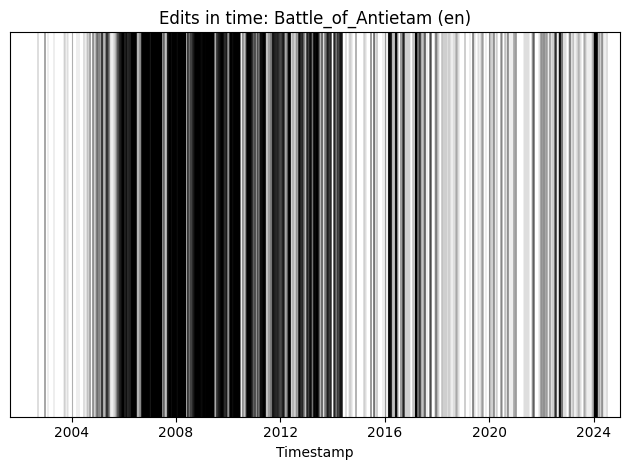

<Figure size 1000x600 with 0 Axes>

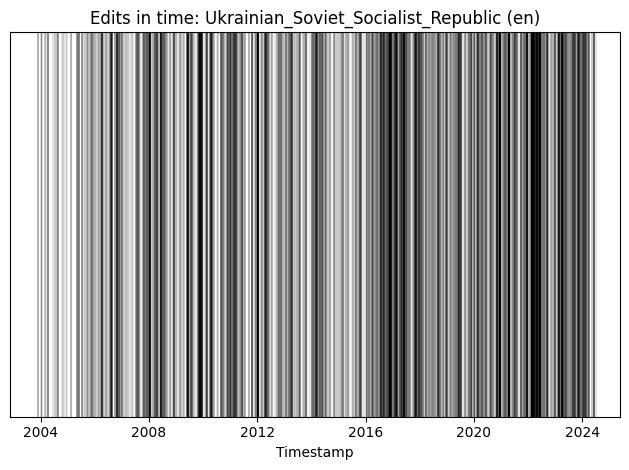

In [50]:
plot_burstiness('Battle_of_Antietam', 'en')
plot_burstiness('Ukrainian_Soviet_Socialist_Republic', 'en')

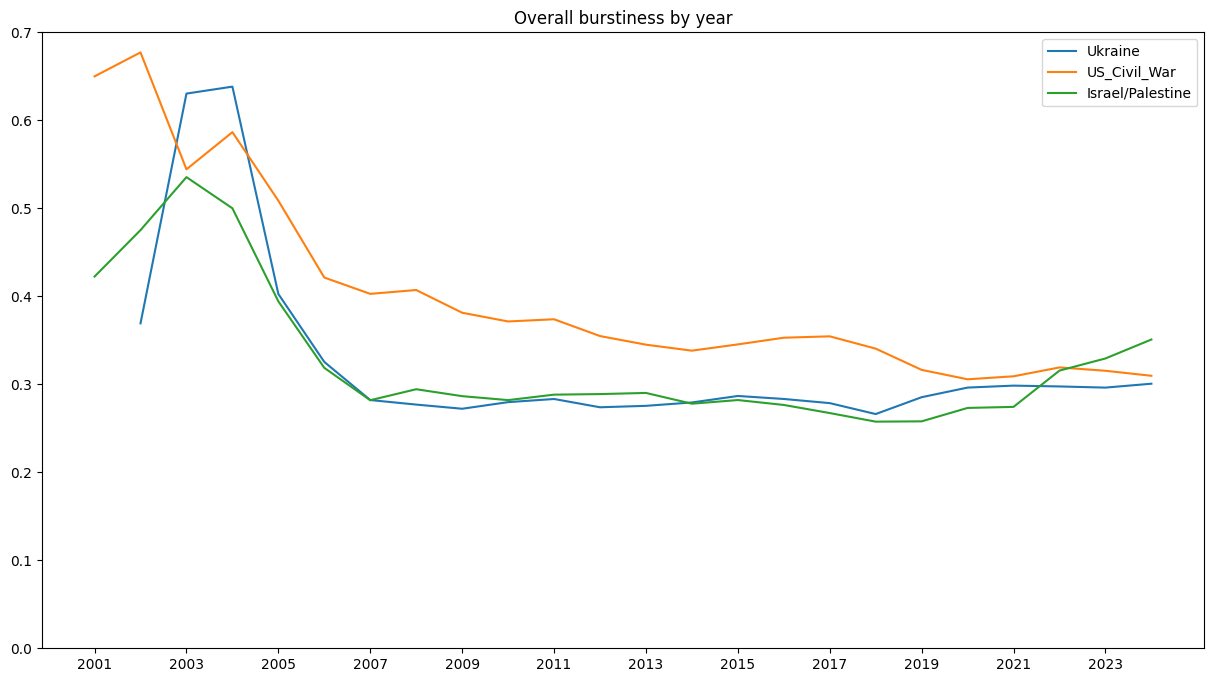

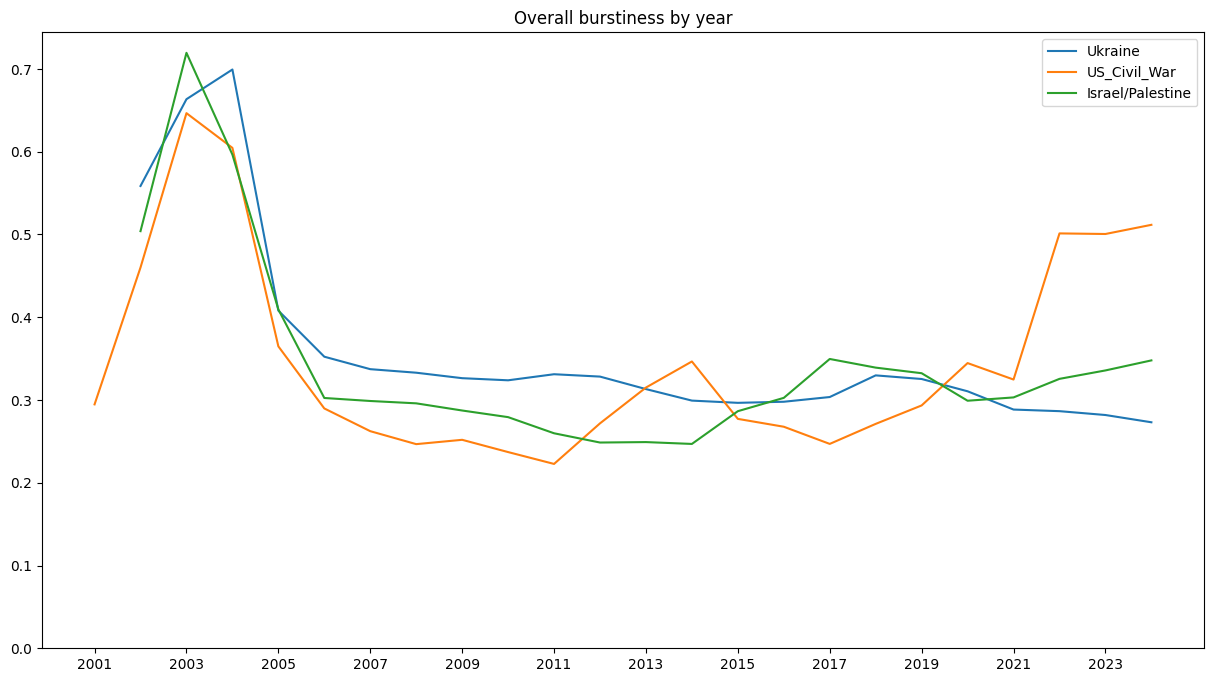

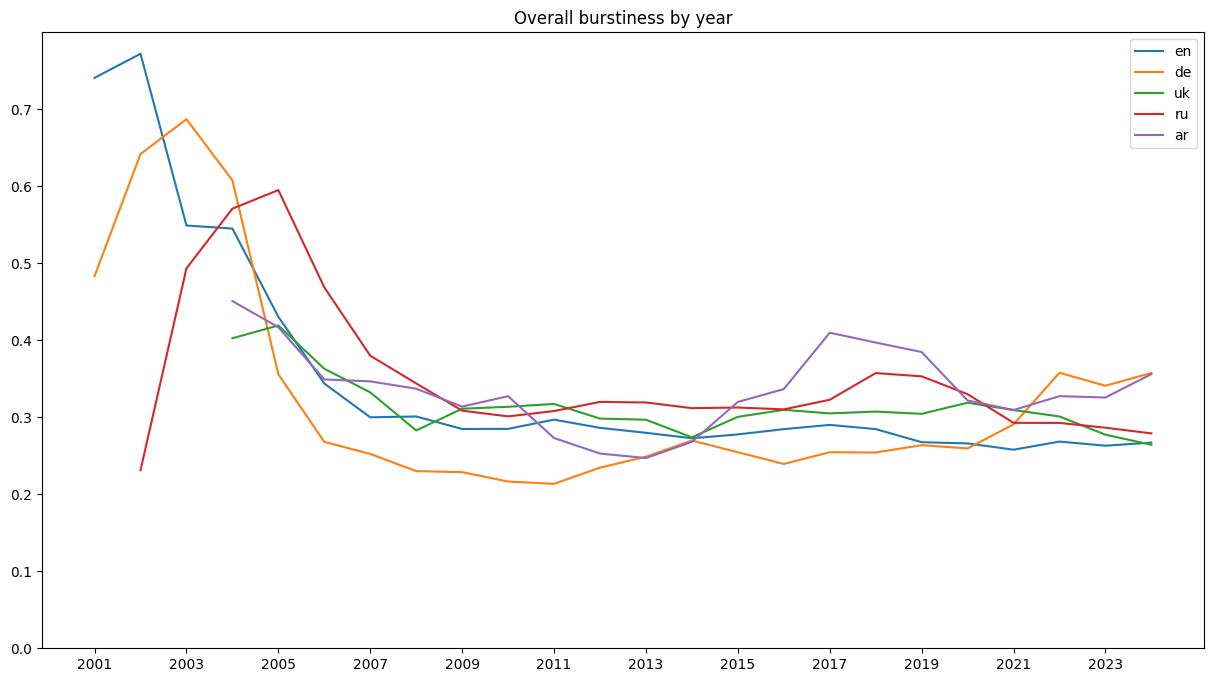

In [51]:
def get_burstiness_in_time(article : str = None, lang : str = None, topic : str = None, edits_df : pd.DataFrame = wikiData_all):

    filtered_df = edits_df

    if article is not None:
        filtered_df = filtered_df[(filtered_df['article'] == article)]

    if lang is not None:
        filtered_df = filtered_df[(filtered_df['language'] == lang)]

    if topic is not None:
        filtered_df = filtered_df[(filtered_df['topic'] == topic)]

    burstiness_dict = {'year' : [], 'burstiness' : []}
    for year in filtered_df['year'].unique():
        df = filtered_df[(filtered_df['year'] == year) | (filtered_df['year'] == year - 1) | (filtered_df['year'] == year + 1)]
        b = burstiness(article, lang, topic, edits_df = df)
        burstiness_dict['year'].append(year)
        burstiness_dict['burstiness'].append(b)
    
    burstiness_df = pd.DataFrame(burstiness_dict)
    return burstiness_df

def plot_burstiness_in_time(group : str = 'language', edits_df : pd.DataFrame = wikiData_all, yearstart : int = None):

    if yearstart is None:
        yearstart = edits_df['year'].min()
    edits_df = edits_df[edits_df['year'] >= yearstart]

    plt.figure(figsize=(15,8))

    for g in edits_df[group].unique():
        df = get_burstiness_in_time(edits_df = edits_df[edits_df[group] == g])
        
        plt.plot(df['year'], df['burstiness'], label=g)
        plt.xticks(range(yearstart, 2025, 2))
        plt.yticks([i / 10 for i in range(0, 8, 1)])
        plt.title("Overall burstiness by year")
        plt.legend()
 

plot_burstiness_in_time('topic', wikiData_all[wikiData_all['language'] == 'en'])
plot_burstiness_in_time('topic', wikiData_all[wikiData_all['language'] != 'en'])
plot_burstiness_in_time()

<Figure size 1000x600 with 0 Axes>

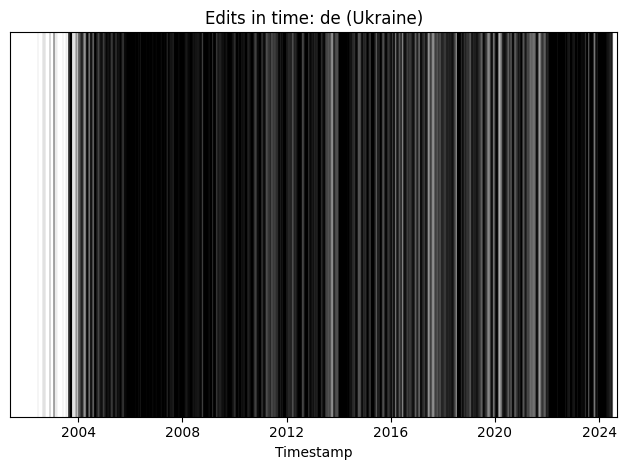

In [52]:
plot_burstiness(lang = 'de', topic = 'Ukraine')


In [53]:
unique_articles.groupby(['topic', 'language']).agg(
    frequency = ('edit_frequency', 'mean'),
    frequency_2010 = ('edit_frequency_2010', 'mean'),
    burstiness = ('burstiness', 'mean'),
    burstiness_2010 = ('burstiness_2010', 'mean')
).reset_index()


,topic,language,frequency,frequency_2010,burstiness,burstiness_2010
0,Israel/Palestine,ar,600.251738,646.107953,0.296030,0.272649
1,Israel/Palestine,de,662.371754,874.534356,0.352326,0.296448
2,Israel/Palestine,en,435.251072,179.968240,0.452975,0.381262
3,US_Civil_War,de,836.728756,1373.206420,0.356223,0.284219
4,US_Civil_War,en,139.855976,149.918366,0.474372,0.386052
5,Ukraine,de,965.865367,1069.174710,0.310198,0.300066
6,Ukraine,en,277.533679,283.629357,0.373129,0.331455
7,Ukraine,ru,247.756288,253.760081,0.406676,0.379669
8,Ukraine,uk,462.720891,453.624626,0.349834,0.344420


## Burstiness and protections

Below, we import files containing information about protections in order to plot article edits and protection ranges in the burstiness plots.

In [54]:
## Importing and cleaning data (same as protection_analysis.ipynb)

protections_US = pd.read_csv("../data/protection_data/protections_Us_Civil_war_2024-07-13-11-04.csv")
protections_US['topic'] = 'US_Civil_War'
protections_UA = pd.read_csv("../data/protection_data/protections_Ukraine_2024-07-14-04-49.csv")
protections_UA['topic'] = 'Ukraine'
protections_IP = pd.read_csv("../data/protection_data/protections_Israel_Palestine_2024-07-13-19-16.csv")
protections_IP['topic'] = 'Israel/Palestine'

protections_all = pd.concat([protections_US, protections_UA, protections_IP]).drop_duplicates()
protections_all['timestamp'] = pd.to_datetime(protections_all['timestamp'])

protections_clean_pm = protections_all[(protections_all['action'] != 'unprotect')].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True]) # & (protections_all['action'] != 'move_prot')
protections_clean_u = protections_all[protections_all['action'] == 'unprotect']

protections_clean_pm['expiry_mod'] = protections_clean_pm['expiry'].fillna(datetime(2029,12,31))
protections_clean_pm = protections_clean_pm.reset_index()

for index, row in protections_clean_pm.iterrows():

    protections_clean_u_al = protections_clean_u[(protections_clean_u['article'] == row['article']) & (protections_clean_u['language'] == row['language'])]
    protections_clean_u_al = protections_clean_u_al[(protections_clean_u_al['timestamp'] > row['timestamp']) & (protections_clean_u_al['timestamp'] < row['expiry_mod'])]
              

    if len(protections_clean_u_al) > 0:
        
        protections_clean_pm.at[index, 'expiry_mod'] = protections_clean_u_al['timestamp'].min()

protections_cleaned = protections_clean_pm[['article', 'language', 'timestamp', 'expiry', 'expiry_mod', 'user', 'type']].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True], ignore_index=True)

protections_cleaned['expiry_mod_mod'] = protections_cleaned['expiry_mod']

for index, row in protections_cleaned.iterrows():
    protections_a_l = protections_cleaned[(protections_cleaned['article'] == row['article']) & (protections_cleaned['language'] == row['language'])]
    protections_a_l = protections_a_l[(protections_a_l['timestamp'] > row['timestamp'])]
    
            
    try:
        protections_a_l = protections_a_l[(protections_a_l['timestamp'] < row['expiry_mod'])]

      
        if len(protections_a_l) > 0:

            protections_cleaned.at[index, 'expiry_mod_mod'] = protections_a_l['timestamp'].min()
        
            
    
    except:
        
        continue


protections_cleaned['expiry_mod'] = pd.to_datetime(protections_cleaned['expiry_mod'])
protections_cleaned['expiry_mod_mod'] = pd.to_datetime(protections_cleaned['expiry_mod_mod'])
protections_cleaned

,article,language,timestamp,expiry,expiry_mod,user,type,expiry_mod_mod
0,1929_Hebron_massacre,en,2007-04-16 16:23:53,2007-04-23 16:23:00,2007-04-23 16:23:00,Thatcher,NaN,2007-04-16 16:34:27
1,1929_Hebron_massacre,en,2007-04-16 16:34:27,2007-04-19 16:34:00,2007-04-19 16:34:00,Thatcher,NaN,2007-04-19 16:34:00
2,1929_Hebron_massacre,en,2007-10-16 20:55:51,2007-10-23 20:55:00,2007-10-23 20:55:00,Penwhale,NaN,2007-10-23 20:55:00
3,1929_Hebron_massacre,en,2014-07-24 20:00:31,2014-08-07 20:00:00,2014-08-07 20:00:00,NawlinWiki,NaN,2014-08-07 20:00:00
4,1929_Hebron_massacre,en,2019-04-29 20:40:37,2029-12-31 23:59:59,2029-12-31 23:59:59,Oshwah,"['edit', 'move']",2029-12-31 23:59:59
...,...,...,...,...,...,...,...,...
1088,Zaporozhian_Cossacks,ru,2022-04-25 19:17:52,2022-05-02 19:17:00,2022-05-02 19:17:00,QBA-bot,"['edit', 'move']",2022-05-02 19:17:00
1089,Zaporozhian_Cossacks,ru,2023-09-27 11:06:22,2023-10-04 11:06:00,2023-10-04 11:06:00,QBA-bot,"['edit', 'move']",2023-10-04 11:06:00
1090,Ze'ev_Jabotinsky,en,2019-11-30 00:27:08,2019-12-30 00:27:00,2019-12-30 00:27:00,Berean Hunter,['edit'],2019-12-30 00:27:00
1091,Ze'ev_Jabotinsky,en,2024-05-02 09:42:26,2024-06-02 09:42:00,2024-05-02 19:34:55,Doug Weller,"['edit', 'move']",2024-05-02 19:34:55


In [55]:
import math

def plot_burstiness_protection(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all, protections : pd.DataFrame = protections_cleaned):

    filtered_df = edits_df[(edits_df['article'] == article) & (edits_df['language'] == lang)]
    filtered_protections = protections[(protections['article'] == article) & (protections['language'] == lang)]

    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
        filtered_protections = protections[protections['timestamp'] >= timestart]

    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]
        filtered_protections = protections[protections['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    plt.figure(figsize=(10, 6))
    lw = 1 / math.sqrt(len(filtered_df) / 100)

    for index, row in filtered_df.iterrows():
        plt.axvline(x=row['timestamp'], color='black', linestyle='-', alpha=0.7, linewidth = lw)
        
    for index, row in filtered_protections.iterrows():
        start = row['timestamp']
        end = row['expiry_mod_mod']
        plt.axvspan(start, end, color='red', alpha=0.3, label='Protected')

    plt.xlabel('Timestamp')
    plt.grid(True)
    plt.tight_layout()

    plt.show()


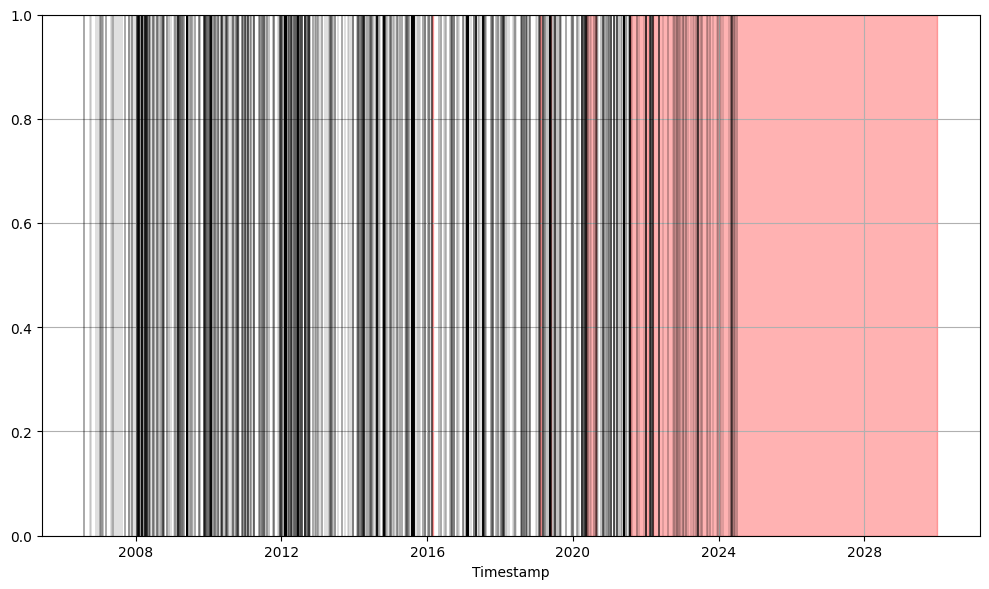

In [56]:
plot_burstiness_protection("Ukrainian_People's_Republic", 'ru')